#### leer este paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6119093/

Elevated expression includes three subcategory types of elevated expression:

Tissue enriched: At least four-fold higher mRNA level in a particular tissue compared to any other tissue.
Group enriched: At least four-fold higher average mRNA level in a group of 2-5 tissues compared to any other tissue.
Tissue enhanced: At least four-fold higher mRNA level in a particular tissue compared to the average level in all other tissues.

In [1]:
%load_ext autoreload
%autoreload 2

In [144]:
import os
import abagen
import json
import nibabel as nib
import seaborn as sns
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib.pyplot as plt
from src.ni_functions import *
from src.tree_functions import *
import pandas as pd

In [141]:
project_path = "/workspaces/bha2"
conn_size = 2165

In [280]:
opt_gamma = 0.7
lvl = 95

tree = json.loads(
    open(
        os.path.join(
            project_path,
            "data",
            "results",
            "n" + str(conn_size),
            "tree_g_" + str(opt_gamma) + ".json",
        )
    ).read()
)
level, labels = level_from_tree(tree, lvl)

In [281]:
roi_heights = nib.load(os.path.join(
        project_path,
        "data",
        "results",
        "n" + str(conn_size),
        "roi_breaks_heights.nii.gz",
    )).get_fdata()
atlas = nib.load(os.path.join(
        project_path,
        "data",
        "results",
        "n" + str(conn_size),
        "initial_partition.nii.gz",
    ))

In [282]:
parcellation4allen = np.zeros((atlas.get_fdata().shape[0], atlas.get_fdata().shape[1], atlas.get_fdata().shape[2]))

module_median_heights = []
for idx, rois in enumerate(level):
    module_vol = get_module_vol(atlas, rois)
    module_heights = roi_heights[module_vol == 1]
    module_median_heights.append(np.median(module_heights))
    parcellation4allen = parcellation4allen + (module_vol*(idx+1)).astype(int)
nib.save(
    nib.Nifti1Image(parcellation4allen, affine=atlas.affine),
    os.path.join(
        project_path,
        "data",
        "results",
        "n" + str(conn_size),
        "parcellation4allen.nii.gz",
    )
)

<Axes: >

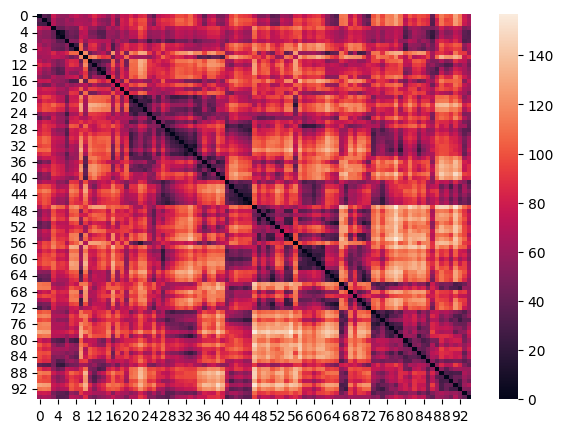

In [283]:
plt.rcParams['figure.figsize'] = [7, 5]
distance_matrix = np.zeros((len(level), len(level)))
for idx_i, mod_i in enumerate(level):
    for idx_j, mod_j in enumerate(level):
        if idx_i == idx_j:
            distance_matrix[idx_i, idx_j] = 0
        else:
            distance_matrix[idx_i, idx_j] = distance_between_modules(np.array(mod_i)+1, np.array(mod_j)+1, atlas)
sns.heatmap(distance_matrix)

In [260]:
atlas_name = "craddock_" + str(conn_size) + ".nii.gz"
atlas = nib.load(os.path.join(project_path, "brain_templates", atlas_name))
atlas_vol = atlas.get_fdata()
optimal_parcellation = nib.load(os.path.join(project_path, "data", "results", "n" + str(conn_size), "optimal_partition_50.nii.gz"))
optimal_parcellation_data = optimal_parcellation.get_fdata()
module_sizes = nib.load(os.path.join(project_path, "data", "results", "n" + str(conn_size), "module_sizes_50.nii.gz")).get_fdata()
module_heights = nib.load(os.path.join(project_path, "data", "results", "n" + str(conn_size), "module_heights_50.nii.gz")).get_fdata()
module_MSI = nib.load(os.path.join(project_path, "data", "results", "n" + str(conn_size), "MSI_50.nii.gz")).get_fdata()
module_idx = np.setdiff1d(np.unique(optimal_parcellation_data), [0]).astype(int)

In [125]:
parcel = np.zeros(optimal_parcellation_data.shape)
parcel_rois = []
idx_parcel = 1
heights_values = []
MSI_values = []
for idx in module_idx:
    module_vol = optimal_parcellation_data == idx
    m_size = np.setdiff1d(np.unique(module_sizes[module_vol]), [0])
    if m_size > 2:
        parcel[module_vol] = idx_parcel
        parcel_rois.append(get_atlas_rois_from_mask(nib.Nifti1Image(module_vol*1.0, affine=optimal_parcellation.affine), atlas))
        heights_values.append(module_heights[module_vol][0])
        MSI_values.append(module_MSI[module_vol][0])
        idx_parcel += 1
parcel_img = nib.Nifti1Image(parcel, affine=optimal_parcellation.affine)


<Axes: >

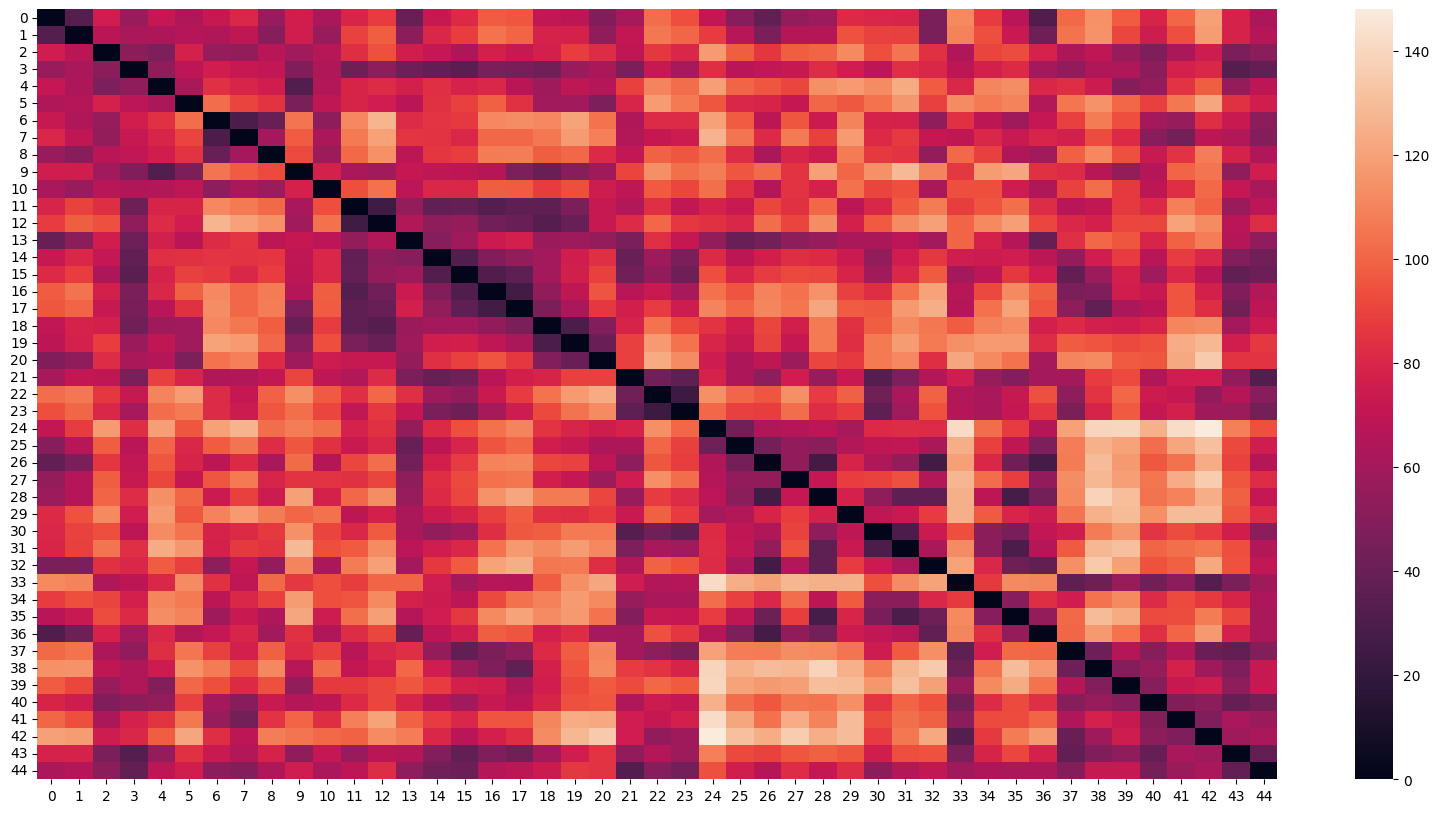

In [126]:
plt.rcParams['figure.figsize'] = [5, 5]
distance_matrix = np.zeros((len(parcel_rois), len(parcel_rois)))
for i in range(len(parcel_rois)):
    for j in range(len(parcel_rois)):
        if i == j:
            distance_matrix[i, j] = 0
        else:
            distance_matrix[i, j] = distance_between_modules(parcel_rois[i], parcel_rois[j], atlas)
sns.heatmap(distance_matrix)

In [284]:
# check if fcm and scm are stored in tmp folder
if os.path.exists(os.path.join(project_path, "tmp", "transcriptome_" + str(len(level)) + "modules.csv")):
    transcriptome = pd.read_csv(os.path.join(project_path, "tmp", "transcriptome_" + str(len(level)) + "modules.csv"))
    print("transcriptome loaded from tmp folder")
else:
    transcriptome = pd.DataFrame.transpose(abagen.get_expression_data(nib.Nifti1Image(parcellation4allen, affine=atlas.affine)))
    transcriptome.to_csv(os.path.join(project_path, "tmp", "transcriptome_" + str(len(level)) + "modules.csv"), index=True)

/usr/local/lib/python3.9/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_by_label = (microarray.groupby('label')
/usr/local/lib/python3.9/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_by_label = (microarray.groupby('label')
/usr/local/lib/python3.9/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_by_label = (microarray.groupby('label')
/usr/local/lib/python3.9/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_by_label = (microarray.groupby('label')
/usr/local/lib/python3.9/sit

<class 'pandas.core.frame.DataFrame'>


<Axes: xlabel='label', ylabel='gene_symbol'>

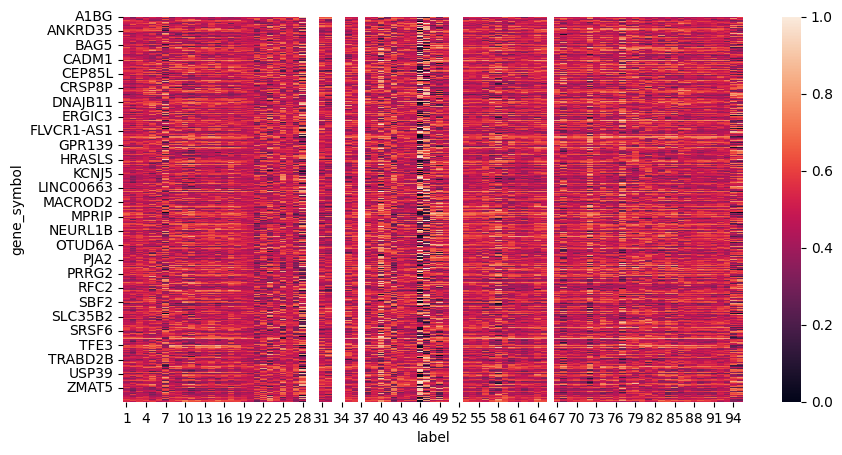

In [285]:
plt.rcParams['figure.figsize'] = [10, 5]
print(type(transcriptome))
sns.heatmap(transcriptome)

In [286]:
brain_genes = pd.read_csv(os.path.join(project_path, "data", "tissue_category_rna_brain_Tissue.tsv"), sep="\t")
brain_gene_names = brain_genes["Gene"].values
brain_gene_expresion = transcriptome.loc[transcriptome.index.isin(brain_gene_names), :]


In [287]:
p_height, t_height = regression_with_transcriptome(np.array(module_median_heights), transcriptome.values, distance_matrix)
pfdr_height = multipletests(p_height, alpha=0.05, method='fdr_bh', is_sorted=False)

/usr/local/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 23 disconnected components.
  warnings.warn(message)
/usr/local/lib/python3.9/site-packages/libpysal/weights/util.py:855: UserWarning: This function is deprecated. Use fill_diagonal instead.
  warn("This function is deprecated. Use fill_diagonal instead.")
/usr/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:870: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [288]:
np.savetxt(os.path.join(project_path, "data", "results", "n" + str(conn_size), "genes_signif.txt"), 
    transcriptome.index[pfdr_height[0]], fmt="%s", delimiter=",", newline="\n")

In [105]:
#compute the pearson correlation between expression and MSI in an effcient way
corr = np.zeros((brain_gene_expresion.shape[0], 2))
for i in range(brain_gene_expresion.shape[0]):
    corr[i, 0] = np.corrcoef(brain_gene_expresion.values[i, :], MSI_values)[0, 1]
    corr[i, 1] = np.corrcoef(brain_gene_expresion.values[i, :], heights_values)[0, 1]
    

Text(0.5, 1.0, 'Correlation between gene expression and module height')

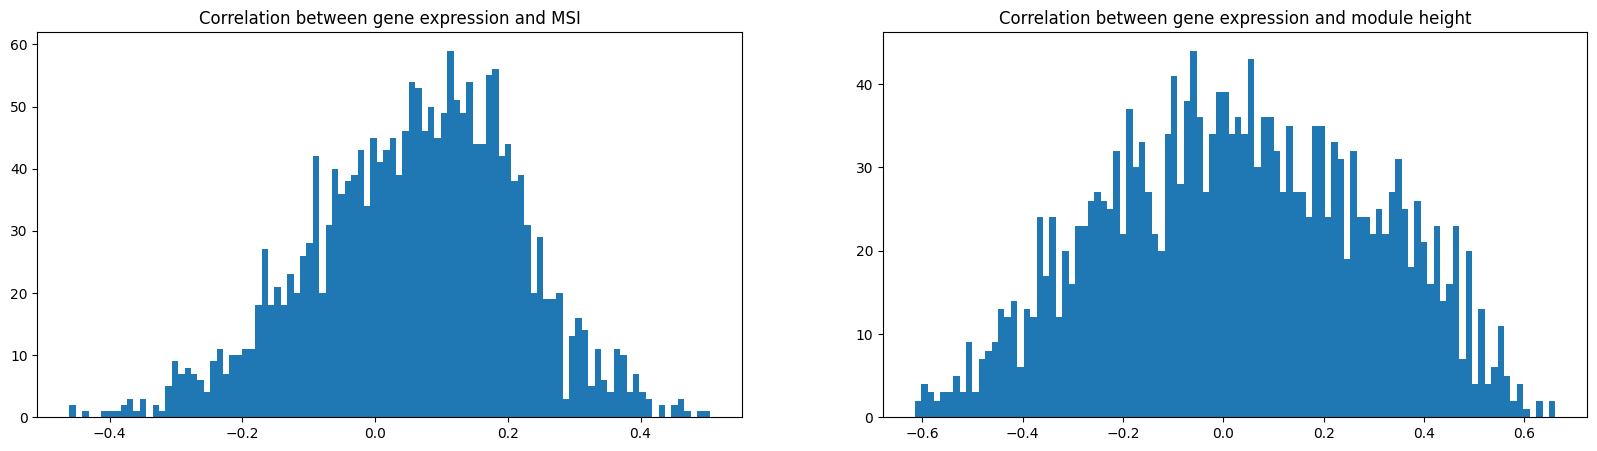

In [106]:
plot, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].hist(corr[:, 0], bins=100)
axes[0].set_title("Correlation between gene expression and MSI")
axes[1].hist(corr[:, 1], bins=100)
axes[1].set_title("Correlation between gene expression and module height")

In [108]:
brain_gene_expresion.shape

(2045, 26)

In [136]:
p_height, t_height = regression_with_transcriptome(np.array(heights_values), brain_gene_expresion.values, distance_matrix)
pfdr_height = multipletests(p_height, alpha=0.05, method='fdr_bh', is_sorted=False)

In [137]:
min(p_height)

2.4130366579903854e-05

In [65]:
transcriptome_mat = transcriptome.values
tissue_enriched_genes = np.zeros((transcriptome_mat.shape[1],transcriptome_mat.shape[1]))
for i in range(transcriptome_mat.shape[1]):
    for j in range(transcriptome_mat.shape[1]):
        if i == j:
            tissue_enriched_genes[i, j] = 0
        else:
            tissue_enriched_genes[i, j] = np.where(transcriptome_mat[:,i]>4*transcriptome_mat[:,j])[0].shape[0]


<Axes: >

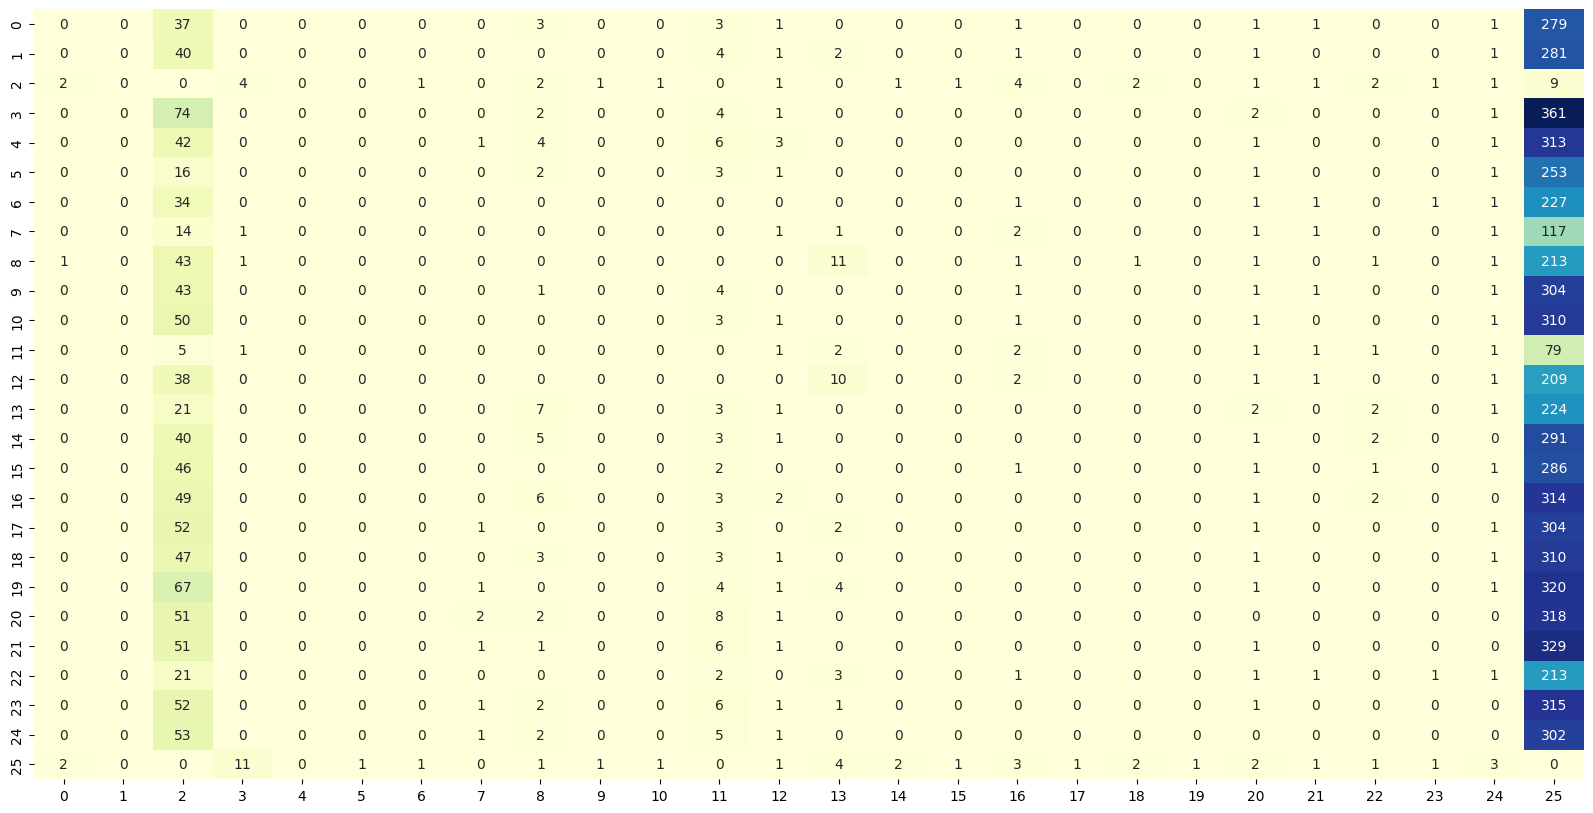

In [94]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.heatmap(tissue_enriched_genes, annot=True, fmt=".0f", cmap="YlGnBu", cbar=False)

In [93]:
tissue_enhaced_genes = np.zeros(transcriptome_mat.shape[1])
mins = []
for i in range(transcriptome_mat.shape[1]):
    out_of_module_mean_profile = np.mean(np.delete(transcriptome_mat, i, axis=1),axis=1)
    tissue_enhaced_genes[i] = np.where(transcriptome_mat[:,i]>4*out_of_module_mean_profile)[0].shape[0]
tissue_enhaced_genes

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])